In [98]:
import numpy as np
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras import optimizers
from keras.layers.normalization import BatchNormalization

In [99]:
IMG_SIZE = (224, 224)  # размер входного изображения сети

In [100]:
import re
from random import shuffle
from glob import glob

train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [ ]:
#shuffle(train_files)
#train_files = train_files[:1000]

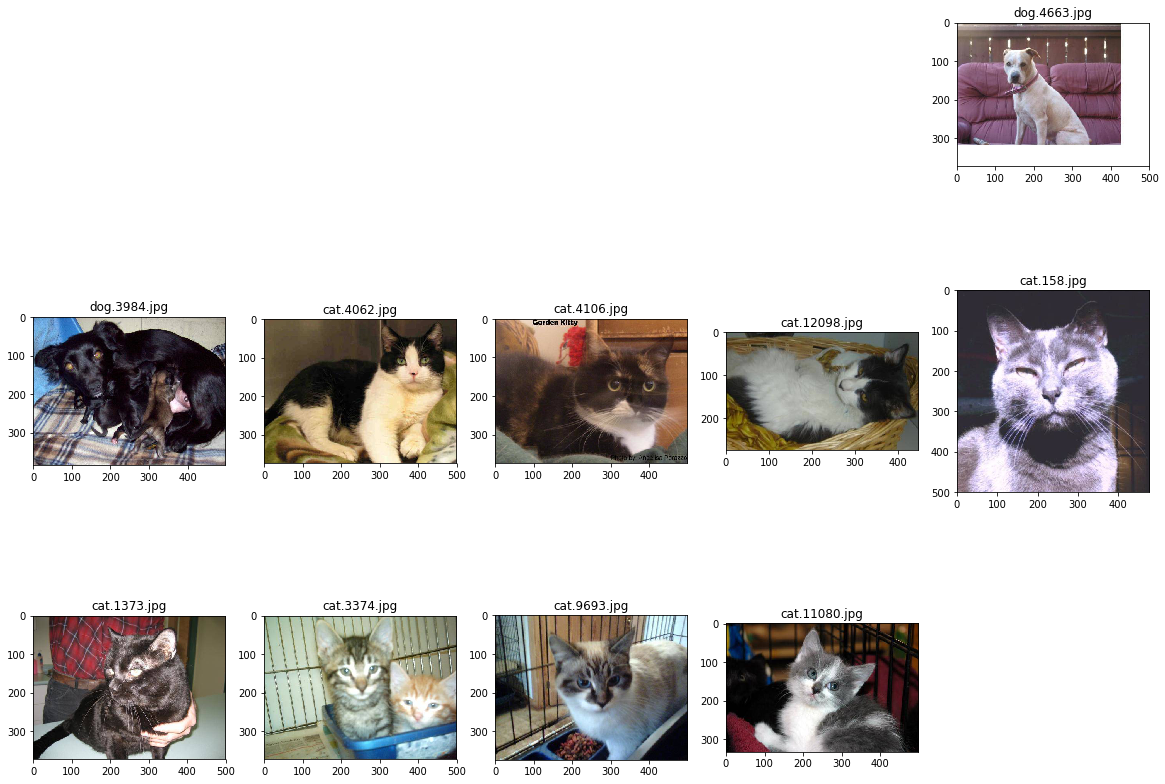

In [101]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1]);

In [102]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

In [103]:
# фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

In [104]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [105]:
x = base_model.layers[-5].output
x = keras.layers.Flatten()(x)
x = BatchNormalization()(x)
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = keras.layers.Dense(1,  # один выход
                activation='sigmoid',  # функция активации  
                kernel_regularizer=keras.regularizers.l2(1e-4))(x)
model = Model(inputs=base_model.input, outputs=x)

In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [107]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [108]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 10s 989ms/step - loss: 0.7106 - acc: 0.7156 - val_loss: 0.5959 - val_acc: 0.8000
Epoch 2/100
10/10 [==============================] - 1s 126ms/step - loss: 0.5144 - acc: 0.8219 - val_loss: 0.4668 - val_acc: 0.8200
Epoch 3/100
10/10 [==============================] - 1s 124ms/step - loss: 0.4370 - acc: 0.8656 - val_loss: 0.3840 - val_acc: 0.8500
Epoch 4/100
10/10 [==============================] - 1s 125ms/step - loss: 0.3911 - acc: 0.8844 - val_loss: 0.3686 - val_acc: 0.8700
Epoch 5/100
10/10 [==============================] - 1s 126ms/step - loss: 0.4362 - acc: 0.9000 - val_loss: 0.3763 - val_acc: 0.8800
Epoch 6/100
10/10 [==============================] - 1s 138ms/step - loss: 0.3704 - acc: 0.8969 - val_loss: 0.3261 - val_acc: 0.8900
Epoch 7/100
10/10 [==============================] - 1s 143ms/step - loss: 0.4498 - acc: 0.8656 - val_loss: 0.3038 - val_acc: 0.9100
Epoch 8/100
10/10 [==============================] - 1s 145ms/step -

10/10 [==============================] - 1s 145ms/step - loss: 0.2518 - acc: 0.9406 - val_loss: 0.1825 - val_acc: 0.9800
Epoch 63/100
10/10 [==============================] - 1s 144ms/step - loss: 0.2494 - acc: 0.9469 - val_loss: 0.1794 - val_acc: 0.9800
Epoch 64/100
10/10 [==============================] - 1s 144ms/step - loss: 0.2678 - acc: 0.9313 - val_loss: 0.1750 - val_acc: 0.9800
Epoch 65/100
10/10 [==============================] - 1s 147ms/step - loss: 0.2244 - acc: 0.9500 - val_loss: 0.1752 - val_acc: 0.9800
Epoch 66/100
10/10 [==============================] - 1s 142ms/step - loss: 0.2897 - acc: 0.9313 - val_loss: 0.1795 - val_acc: 0.9600
Epoch 67/100
10/10 [==============================] - 1s 145ms/step - loss: 0.2323 - acc: 0.9500 - val_loss: 0.1847 - val_acc: 0.9600
Epoch 68/100
10/10 [==============================] - 1s 142ms/step - loss: 0.3081 - acc: 0.9094 - val_loss: 0.1948 - val_acc: 0.9500
Epoch 69/100
10/10 [==============================] - 1s 142ms/step - loss:

In [111]:
model.save('cats-dogs-vgg16.hdf5')

In [112]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

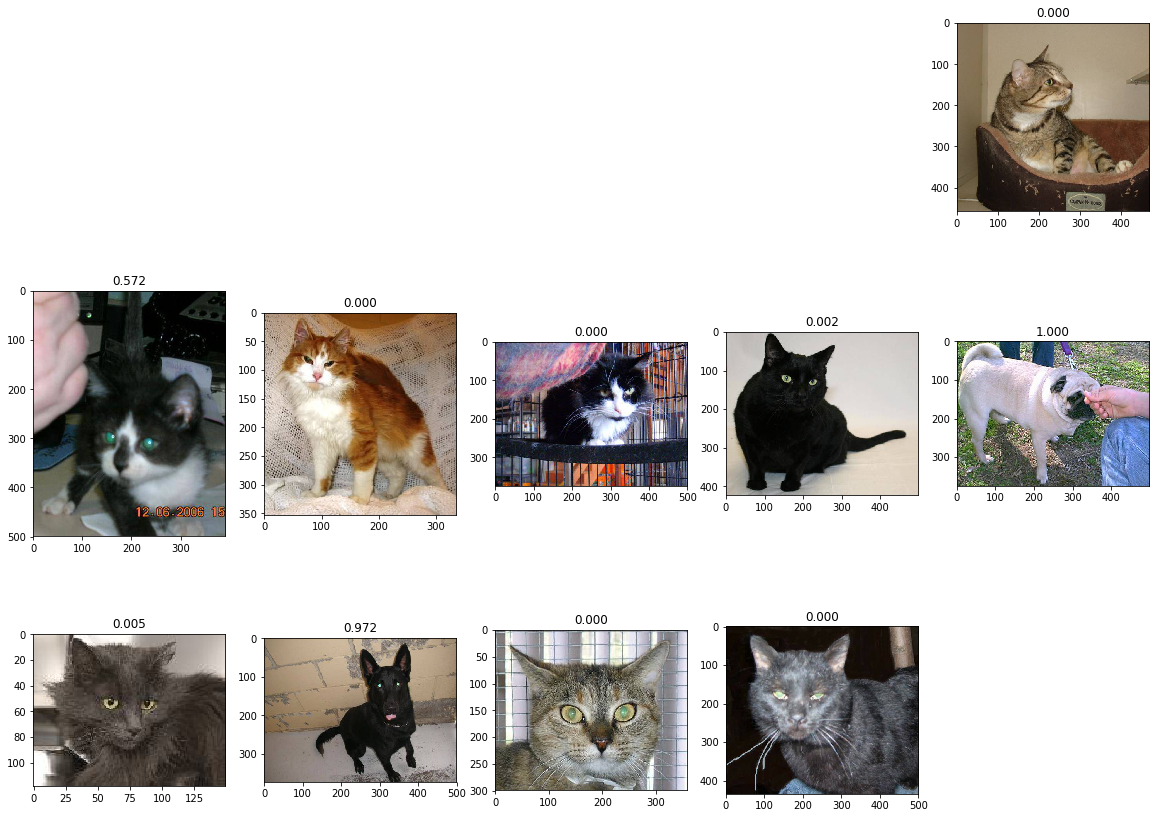

In [113]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

In [114]:
with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))